In [4]:
#Downloading the dataset
!mkdir dataset
%cd dataset
!wget https://cv.snu.ac.kr/research/VDSR/train_data.zip
!wget https://cv.snu.ac.kr/research/VDSR/test_data.zip
!unzip train_data.zip
!unzip test_data.zip
%cd ..

/content/dataset
--2018-11-15 00:51:06--  https://cv.snu.ac.kr/research/VDSR/train_data.zip
Resolving cv.snu.ac.kr (cv.snu.ac.kr)... 147.46.116.247
Connecting to cv.snu.ac.kr (cv.snu.ac.kr)|147.46.116.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41628740 (40M) [application/zip]
Saving to: ‘train_data.zip’

train_data.zip      100%[===================>]  39.70M  5.11MB/s    in 8.7s    

2018-11-15 00:51:16 (4.56 MB/s) - ‘train_data.zip’ saved [41628740/41628740]

--2018-11-15 00:51:16--  https://cv.snu.ac.kr/research/VDSR/test_data.zip
Resolving cv.snu.ac.kr (cv.snu.ac.kr)... 147.46.116.247
Connecting to cv.snu.ac.kr (cv.snu.ac.kr)|147.46.116.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62972123 (60M) [application/zip]
Saving to: ‘test_data.zip’

test_data.zip       100%[===================>]  60.05M  4.93MB/s    in 13s     

2018-11-15 00:51:30 (4.58 MB/s) - ‘test_data.zip’ saved [62972123/62972123]

Archive:  train_data

In [0]:
#Importing the required packages
from pathlib import Path
import random
import numpy as np
import cv2
import string
import os
from keras.utils import Sequence
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Add, PReLU, Conv2DTranspose, Concatenate, MaxPooling2D, UpSampling2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.optimizers import Adam

In [6]:
#install ngrok, to tunnel the tensorboard to a different link. 
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-11-15 00:51:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.237.103, 34.206.36.121, 34.206.253.53, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.237.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]   5.11M  9.62MB/s    in 0.5s    

2018-11-15 00:51:55 (9.62 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [0]:
class NoisyImageGenerator(Sequence):
  
  def __init__(self, image_dir, source_noise_model, target_noise_model, batch_size=32, image_size=64):

    self.image_paths = list(Path(image_dir).glob("*.jpg"))
    self.source_noise_model = source_noise_model
    self.target_noise_model = target_noise_model
    self.image_num = len(self.image_paths)
    self.batch_size = batch_size
    self.image_size = image_size

  def __len__(self):

    return self.image_num // self.batch_size

  def __getitem__(self, idx):

    batch_size = self.batch_size
    image_size = self.image_size
    x = np.zeros((batch_size, image_size, image_size, 3), dtype=np.uint8)
    y = np.zeros((batch_size, image_size, image_size, 3), dtype=np.uint8)
    sample_id = 0

    while True:
      
      image_path = random.choice(self.image_paths)
      image = cv2.imread(str(image_path))
      h, w, _ = image.shape

      if h >= image_size and w >= image_size:
          h, w, _ = image.shape
          i = np.random.randint(h - image_size + 1)
          j = np.random.randint(w - image_size + 1)
          clean_patch = image[i:i + image_size, j:j + image_size]
          x[sample_id] = self.source_noise_model(clean_patch)
          y[sample_id] = self.target_noise_model(clean_patch)

          sample_id += 1

          if sample_id == batch_size:
              return x, y


class ValGenerator(Sequence):
  
    def __init__(self, image_dir, val_noise_model):
      
        image_paths = list(Path(image_dir).glob("*.*"))
        self.image_num = len(image_paths)
        self.data = []

        for image_path in image_paths:
            y = cv2.imread(str(image_path))
            h, w, _ = y.shape
            y = y[:(h // 16) * 16, :(w // 16) * 16]  # for stride (maximum 16)
            x = val_noise_model(y)
            self.data.append([np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)])

    def __len__(self):
        return self.image_num

    def __getitem__(self, idx):
        return self.data[idx]

In [0]:
def get_noise_model(noise_type="gaussian,0,50"):
  
    tokens = noise_type.split(sep=",")

    if tokens[0] == "gaussian":
        min_stddev = int(tokens[1])
        max_stddev = int(tokens[2])

        def gaussian_noise(img):
            noise_img = img.astype(np.float)
            stddev = np.random.uniform(min_stddev, max_stddev)
            noise = np.random.randn(*img.shape) * stddev
            noise_img += noise
            noise_img = np.clip(noise_img, 0, 255).astype(np.uint8)
            return noise_img
          
        return gaussian_noise
      
    elif tokens[0] == "clean":
        return lambda img: img
      
    elif tokens[0] == "text":
      
        min_occupancy = int(tokens[1])
        max_occupancy = int(tokens[2])

        def add_text(img):
          
            img = img.copy()
            h, w, _ = img.shape
            font = cv2.FONT_HERSHEY_SIMPLEX
            img_for_cnt = np.zeros((h, w), np.uint8)
            occupancy = np.random.uniform(min_occupancy, max_occupancy)

            while True:
                n = random.randint(5, 10)
                random_str = ''.join([random.choice(string.ascii_letters + string.digits) for i in range(n)])
                font_scale = np.random.uniform(0.5, 1)
                thickness = random.randint(1, 3)
                (fw, fh), baseline = cv2.getTextSize(random_str, font, font_scale, thickness)
                x = random.randint(0, max(0, w - 1 - fw))
                y = random.randint(fh, h - 1 - baseline)
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                cv2.putText(img, random_str, (x, y), font, font_scale, color, thickness)
                cv2.putText(img_for_cnt, random_str, (x, y), font, font_scale, 255, thickness)

                if (img_for_cnt > 0).sum() > h * w * occupancy / 100:
                    break
            return img
          
        return add_text
      
      
    elif tokens[0] == "impulse":
      
        min_occupancy = int(tokens[1])
        max_occupancy = int(tokens[2])

        def add_impulse_noise(img):
            occupancy = np.random.uniform(min_occupancy, max_occupancy)
            mask = np.random.binomial(size=img.shape, n=1, p=occupancy / 100)
            noise = np.random.randint(256, size=img.shape)
            img = img * (1 - mask) + noise * mask
            return img.astype(np.uint8)
        return add_impulse_noise


#def showDenoisedImage():
#
#    imageSize = 256
#    noise_model = get_noise_model("text,0,10")
#
#    while True:
#        
#        image = np.ones((imageSize, imageSize, 3), dtype=np.uint8) * 128
#        noisy_image = noise_model(image)
#        plt.imshow(noisy_image)
#        plt.show()
#        break
#        key = cv2.waitKey(-1)
#
#        # "q": quit
#        if key == 113:
#            return 0
#
#showDenoisedImage()

In [0]:
class L0Loss:
  
  def __init__(self):
    
    self.gamma = K.variable(2.)

  def __call__(self):
    
    def calc_loss(y_true, y_pred):
        loss = K.pow(K.abs(y_true - y_pred) + 1e-8, self.gamma)
        return loss
    return calc_loss


class UpdateAnnealingParameter(Callback):
  
    def __init__(self, gamma, nb_epochs, verbose=0):
      
      super(UpdateAnnealingParameter, self).__init__()
      self.gamma = gamma
      self.nb_epochs = nb_epochs
      self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
      
      new_gamma = 2.0 * (self.nb_epochs - epoch) / self.nb_epochs
      K.set_value(self.gamma, new_gamma)

      if self.verbose > 0:
          print('\nEpoch %05d: UpdateAnnealingParameter reducing gamma to %s.' % (epoch + 1, new_gamma))


def tf_log10(x):
  
  numerator = tf.log(x)
  denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator


def PSNR(y_true, y_pred):
  
  max_pixel = 255.0
  y_pred = K.clip(y_pred, 0.0, 255.0)
  return 10.0 * tf_log10((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))


def get_model(model_name="srresnet"):
  
  if model_name == "srresnet":
      return get_srresnet_model()
  elif model_name == "unet":
      return get_unet_model(out_ch=3)


# SRResNet
def get_srresnet_model(input_channel_num=3, feature_dim=64, resunit_num=16):
  
    def _residual_block(inputs):
        x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
        x = BatchNormalization()(x)
        x = PReLU(shared_axes=[1, 2])(x)
        x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        m = Add()([x, inputs])

        return m

    inputs = Input(shape=(None, None, input_channel_num))
    x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
    x = PReLU(shared_axes=[1, 2])(x)
    x0 = x

    for i in range(resunit_num):
        x = _residual_block(x)

    x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Add()([x, x0])
    x = Conv2D(input_channel_num, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    model = Model(inputs=inputs, outputs=x)

    return model

#UNET
def get_unet_model(input_channel_num=3, out_ch=3, start_ch=64, depth=4, inc_rate=2., activation='relu',
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    def _conv_block(m, dim, acti, bn, res, do=0):
        n = Conv2D(dim, 3, activation=acti, padding='same')(m)
        n = BatchNormalization()(n) if bn else n
        n = Dropout(do)(n) if do else n
        n = Conv2D(dim, 3, activation=acti, padding='same')(n)
        n = BatchNormalization()(n) if bn else n

        return Concatenate()([m, n]) if res else n

    def _level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
        if depth > 0:
            n = _conv_block(m, dim, acti, bn, res)
            m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
            m = _level_block(m, int(inc * dim), depth - 1, inc, acti, do, bn, mp, up, res)
            if up:
                m = UpSampling2D()(m)
                m = Conv2D(dim, 2, activation=acti, padding='same')(m)
            else:
                m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
            n = Concatenate()([n, m])
            m = _conv_block(n, dim, acti, bn, res)
        else:
            m = _conv_block(m, dim, acti, bn, res, do)

        return m

    i = Input(shape=(None, None, input_channel_num))
    o = _level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1)(o)
    model = Model(inputs=i, outputs=o)

    return model



In [10]:
class Schedule:
  
  def __init__(self, nb_epochs, initial_lr):

    self.epochs = nb_epochs
    self.initial_lr = initial_lr

  def __call__(self, epoch_idx):

    if epoch_idx < self.epochs * 0.25:
        return self.initial_lr
    elif epoch_idx < self.epochs * 0.50:
        return self.initial_lr * 0.5
    elif epoch_idx < self.epochs * 0.75:
        return self.initial_lr * 0.25
    return self.initial_lr * 0.125

def train():
  
  image_dir = "dataset/291"
  test_dir =  "dataset/Set14"
  image_size = 128
  batch_size = 8
  nb_epochs = 10
  lr = 0.001
  steps = 1000
  loss_type = "mae"
  os.path.dirname(os.path.abspath("__file__"))
  output_path = Path("__file__").resolve().parent.joinpath("text")
  model = get_model("unet")
  opt = Adam(lr=lr)
  callbacks = []

  if loss_type == "l0":
      l0 = L0Loss()
      callbacks.append(UpdateAnnealingParameter(l0.gamma, nb_epochs, verbose=1))
      loss_type = l0()
      
  #This line will generate a link, which would have tensorboard running. Confirguration for the first model. 
  LOG_DIR = './log'
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
      .format(LOG_DIR)
  )
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

  #Actual training of model 1
  callbacks.append(TensorBoard(log_dir='./log'))

  model.compile(optimizer=opt, loss=loss_type, metrics=[PSNR])
  source_noise_model = get_noise_model("text,0,50")
  target_noise_model = get_noise_model( "text,0,50")
  val_noise_model = get_noise_model("text,25,25")
  generator = NoisyImageGenerator(image_dir, source_noise_model, target_noise_model, batch_size=batch_size,
                                  image_size=image_size)
  val_generator = ValGenerator(test_dir, val_noise_model)
  output_path.mkdir(parents=True, exist_ok=True)
  callbacks.append(LearningRateScheduler(schedule=Schedule(nb_epochs, lr)))
  callbacks.append(ModelCheckpoint(str(output_path) + "/weights.{epoch:03d}-{val_loss:.3f}-{val_PSNR:.5f}.hdf5",
                                   monitor="val_PSNR",
                                   verbose=1,
                                   mode="max",
                                   save_best_only=True))
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    hist = model.fit_generator(generator=generator,
                             steps_per_epoch=steps,
                             epochs=nb_epochs,
                             validation_data=val_generator,
                             verbose=1,
                             callbacks=callbacks)
    np.savez(str(output_path.joinpath("history.npz")), history=hist.history)
    sess.close()


train()

http://bfcc3d09.ngrok.io
Epoch 1/10
1000/1000 [==============================] - 458s 458ms/step - loss: 35.4953 - PSNR: 13.2516 - val_loss: 17.8722 - val_PSNR: 19.4457

Epoch 00001: val_PSNR improved from -inf to 19.44567, saving model to /content/text/weights.001-17.872-19.44567.hdf5
Epoch 2/10
1000/1000 [==============================] - 401s 401ms/step - loss: 30.2591 - PSNR: 13.7276 - val_loss: 14.4163 - val_PSNR: 20.5584

Epoch 00002: val_PSNR improved from 19.44567 to 20.55841, saving model to /content/text/weights.002-14.416-20.55841.hdf5
Epoch 3/10
1000/1000 [==============================] - 400s 400ms/step - loss: 28.7161 - PSNR: 13.8343 - val_loss: 11.6140 - val_PSNR: 22.0048

Epoch 00003: val_PSNR improved from 20.55841 to 22.00481, saving model to /content/text/weights.003-11.614-22.00481.hdf5
Epoch 4/10
1000/1000 [==============================] - 400s 400ms/step - loss: 27.5190 - PSNR: 13.8472 - val_loss: 10.0409 - val_PSNR: 22.7326

Epoch 00004: val_PSNR improved from 

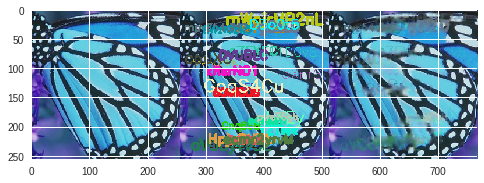

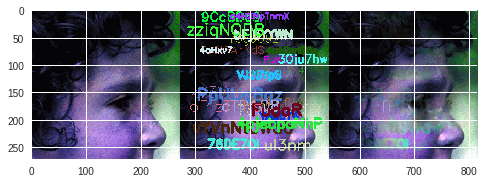

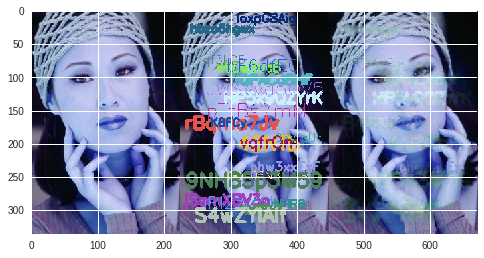

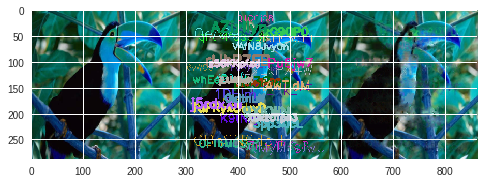

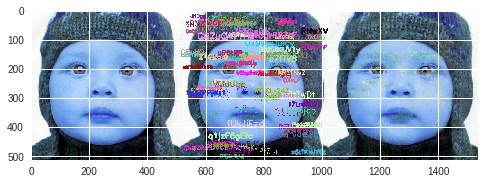

In [12]:
#Testing the model - 

def getImage(image):
    image = np.clip(image, 0, 255)
    return image.astype(dtype=np.uint8)


def test():

    image_dir = "dataset/Set5"
    weight_file = "text/weights.010-7.825-24.27309.hdf5"
    val_noise_model = get_noise_model("text,25,25")
    model = get_model("unet")
    model.load_weights(weight_file)
    output_dir = Path("textOutput")
    output_dir.mkdir(parents=True, exist_ok=True)

    image_paths = list(Path(image_dir).glob("*.*"))
    
    for image_path in image_paths:
        image = cv2.imread(str(image_path))
        h, w, _ = image.shape
        image = image[:(h // 16) * 16, :(w // 16) * 16]  # for stride (maximum 16)
        h, w, _ = image.shape

        out_image = np.zeros((h, w * 3, 3), dtype=np.uint8)
        noise_image = val_noise_model(image)
        pred = model.predict(np.expand_dims(noise_image, 0))
        denoised_image = getImage(pred[0])
        out_image[:, :w] = image
        out_image[:, w:w * 2] = noise_image
        out_image[:, w * 2:] = denoised_image

        cv2.imwrite(str(output_dir.joinpath(image_path.name))[:-4] + ".png", out_image)
        plt.imshow(out_image)
        plt.show()
        key = cv2.waitKey(-1)
        # "q": quit
        if key == 113:
            return 0


test()

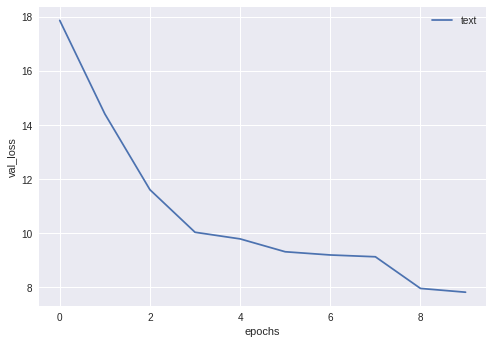

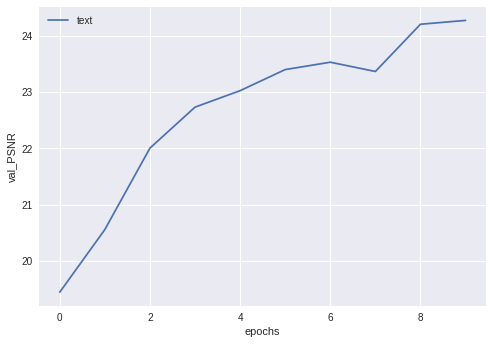

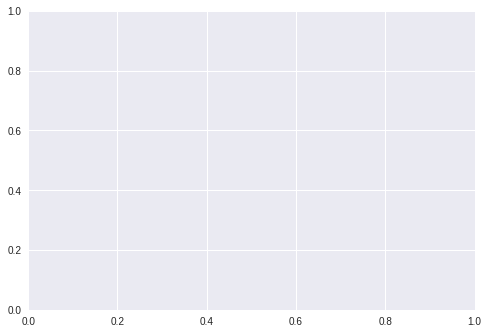

In [13]:
#Plot History
def getPlots():
 
    input_paths = [Path("text").joinpath("history.npz")]
    dateDict = [(np.array(np.load(str(input_path))["history"], ndmin=1)[0], input_path.parent.name)
             for input_path in input_paths]
    metrics = ["val_loss", "val_PSNR"]

    for metric in metrics:
        for data, setting_name in dateDict:
            plt.plot(data[metric], label=setting_name)
        plt.xlabel("epochs")
        plt.ylabel(metric)
        plt.legend()
        plt.savefig(metric + ".png")
        plt.show()
        plt.cla()
        
        
getPlots()
